In [1]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data_utils import (
    calculate_all_metrics,
    read_files,
    results2df,
    return_ct_location_segments,
)
from plot_utils import (
    plot_heatmap,
    plot_map_values,
    plot_training_progression,
    plot_training_progression_with_variation,
)

plt.style.use("science")

**Load annotations and results**

In [2]:
# model name
model_name = "slow_r50"
folder_path = "../dataset/results/training_progression"
metadata_file = "../dataset/metadata/metadata.csv"
behavioural_labels_file = "../dataset/metadata/behaviours.txt"
segements_file = "../dataset/metadata/segments.txt"
figure_saving_path = "../figures/training_progression"


splits = [
    "train",
    "validation",
]

# create saving directory
if not os.path.exists(figure_saving_path):
    os.makedirs(figure_saving_path)


# list all result files in the folder which end with .pkl and contain the model name
result_info = {}

for split in splits:
    for file in os.listdir(os.path.join(folder_path, split)):
        if file.endswith(".pkl") and model_name in file:
            epoch = file.split("_")[-2].split("-")[-1]

            # get the split from the file name
            data_split = file.split("=")[-1].split(".")[0]

            # add model to the dictionary
            if model_name not in result_info:
                result_info[model_name] = {}
            # add epoch to the dictionary
            if epoch not in result_info[model_name]:
                result_info[model_name][epoch] = {}
            if split not in result_info[model_name][epoch]:
                result_info[model_name][epoch][data_split] = {}
            result_info[model_name][epoch][data_split] = {
                "file_path": os.path.join(folder_path, split, file),
            }

In [3]:
metadata_df = pd.read_csv(metadata_file)

with open(behavioural_labels_file, "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

with open(segements_file, "rb") as f:
    segments = [seg.decode("utf-8").strip() for seg in f.readlines()]

# build dict for behavioural where key is the segment and value is the behaviour is the same index
behavioural_dict = {}
for i, (b, s) in enumerate(zip(behaviours, segments)):
    if s not in behavioural_dict:
        behavioural_dict[s] = []
    behavioural_dict[s].append(b)



In [4]:
labels = ["Head", "Tail", "Few-shot"]
reordered_behaviours = [
    "resting",
    "travel",
    "bipedal",
    "camera_reaction",
    "climbing",
    "feeding",
    "grooming",
    "object_carrying",
    "tool_use",
    "vocalisation",
    "aggression",
    "display",
    "piloerection",
    "playing",
]


# Merge behavior data into final_train_data
# "h", "t", "f" are the segments of camera locations
# "head", "tail", "few_shot" are the segments of behaviors
# so if we have a key "map_h_head_values" it means that the values are for the head segment of the camera locations and the head segment of the behaviors
# Here we aggregate the values of the behaviors for each segment of the camera locations
key_map = {
    "map_h_head_values": "head",
    "map_h_tail_values": "head",
    "map_h_fs_values": "head",
    "map_t_head_values": "tail",
    "map_t_tail_values": "tail",
    "map_t_fs_values": "tail",
    "map_f_head_values": "few_shot",
    "map_f_tail_values": "few_shot",
    "map_f_fs_values": "few_shot",
}

datas = {}


for m in result_info:
    for epoch in result_info[m]:
        train_data, val_data = read_files(result_info[model_name], epoch)
        train_df, val_df = results2df(train_data, val_data, metadata_df)

        train_segments = {}
        val_segments = {}

        # Modified segment calculations
        th_df, tt_df, tf_df = return_ct_location_segments(train_df, head=50, tail=5)

        vh_df = val_df[val_df["utm"].isin(th_df["utm"])]
        vt_df = val_df[val_df["utm"].isin(tt_df["utm"])]
        vf_df = val_df[val_df["utm"].isin(tf_df["utm"])]

        train_segments["h"] = th_df.merge(train_df, on="utm", how="left")
        train_segments["t"] = tt_df.merge(train_df, on="utm", how="left")
        train_segments["f"] = tf_df.merge(train_df, on="utm", how="left")

        val_segments["h"] = vh_df
        val_segments["t"] = vt_df
        val_segments["f"] = vf_df

        train_metrics = calculate_all_metrics(
            train_segments, behaviours, segments, show_per_class=True
        )
        val_metrics = calculate_all_metrics(
            val_segments, behaviours, segments, show_per_class=True
        )

        train_data = np.array(
            [
                [
                    train_metrics["map_h_head"],
                    train_metrics["map_h_tail"],
                    train_metrics["map_h_fs"],
                ],
                [
                    train_metrics["map_t_head"],
                    train_metrics["map_t_tail"],
                    train_metrics["map_t_fs"],
                ],
                [
                    train_metrics["map_f_head"],
                    train_metrics["map_f_tail"],
                    train_metrics["map_f_fs"],
                ],
            ]
        ).T

        val_data = np.array(
            [
                [
                    val_metrics["map_h_head"],
                    val_metrics["map_h_tail"],
                    val_metrics["map_h_fs"],
                ],
                [
                    val_metrics["map_t_head"],
                    val_metrics["map_t_tail"],
                    val_metrics["map_t_fs"],
                ],
                [
                    val_metrics["map_f_head"],
                    val_metrics["map_f_tail"],
                    val_metrics["map_f_fs"],
                ],
            ]
        ).T

        # plot for each behaviour the performance for head, tail and few-shot segments

        # Extract and merge behavior data
        train_behaviour_data = defaultdict(dict)
        val_behaviour_data = defaultdict(dict)

        for key in key_map.keys():
            v = [list(d.values())[0] for d in train_metrics[key]]
            k = [list(d.keys())[0] for d in train_metrics[key]]
            # print(f"train mAP {key}: {sum(v) / len(v)}")
            for i, value in enumerate(v):
                train_behaviour_data[key][k[i]] = value

            v = [list(d.values())[0] for d in val_metrics[key]]
            k = [list(d.keys())[0] for d in val_metrics[key]]
            # print(f"val mAP for {key}: {sum(v) / len(v)}")
            for i, value in enumerate(v):
                val_behaviour_data[key][k[i]] = value

        # Initialize final_train_data with keys head, tail, few_shot
        final_train_data = {seg: {} for seg in set(list(key_map.values()))}
        final_val_data = {seg: {} for seg in set(list(key_map.values()))}

        for k, v in train_behaviour_data.items():
            if k in key_map:
                final_train_data[key_map[k]].update(v)

        for k, v in val_behaviour_data.items():
            if k in key_map:
                final_val_data[key_map[k]].update(v)

        # Prepare data matrix
        train_data_matrix = np.array(
            [
                [final_train_data["head"][beh] for beh in reordered_behaviours],
                [final_train_data["tail"][beh] for beh in reordered_behaviours],
                [final_train_data["few_shot"][beh] for beh in reordered_behaviours],
            ]
        ).T
        val_data_matrix = np.array(
            [
                [final_val_data["head"][beh] for beh in reordered_behaviours],
                [final_val_data["tail"][beh] for beh in reordered_behaviours],
                [final_val_data["few_shot"][beh] for beh in reordered_behaviours],
            ]
        ).T

        # add epoch to the dictionary
        if epoch not in datas.keys():
            datas[epoch] = {
                "train_data": {},
                "val_data": {},
                "train_data_matrix": {},
                "val_data_matrix": {},
            }

        # add data to the dictionary
        datas[epoch]["train_data"] = train_data
        datas[epoch]["val_data"] = val_data
        datas[epoch]["train_data_matrix"] = train_data_matrix
        datas[epoch]["val_data_matrix"] = val_data_matrix

/home/kukushkin/anaconda3/envs/slowfast/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/kukushkin/anaconda3/envs/slowfast/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/kukushkin/anaconda3/envs/slowfast/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/kukushkin/anaconda3/envs/slowfast/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for

In [5]:
for epoch in datas.keys():
    train_hmap = datas[epoch]["train_data"][:, 0].mean()
    val_hmap = datas[epoch]["val_data"][:, 0].mean()

    train_tmap = datas[epoch]["train_data"][:, 1].mean()
    val_tmap = datas[epoch]["val_data"][:, 1].mean()

    train_fsmap = datas[epoch]["train_data"][:, 2].mean()
    val_fsmap = datas[epoch]["val_data"][:, 2].mean()

    datas[epoch]["map"] = {
        "train_head_loc": train_hmap,
        "val_head_loc": val_hmap,
        "train_tail_loc": train_tmap,
        "val_tail_loc": val_tmap,
        "train_few_shot_loc": train_fsmap,
        "val_few_shot_loc": val_fsmap,
    }

In [13]:
epoch_oder = [int(e) for e in datas.keys()]

# sort the dictionary by epoch
datas = dict(sorted(datas.items(), key=lambda item: int(item[0])))

print(datas.keys())


datas["200"]["train_data_matrix"]

dict_keys(['1', '5', '10', '20', '40', '80', '100', '160', '200'])


array([[0.999, 1.   , 1.   ],
       [0.998, 0.998, 1.   ],
       [1.   , 1.   , 1.   ],
       [1.   , 1.   , 1.   ],
       [0.998, 1.   , 1.   ],
       [0.999, 1.   , 1.   ],
       [0.996, 0.993, 1.   ],
       [1.   , 1.   , 1.   ],
       [1.   , 1.   , 1.   ],
       [1.   , 1.   , 1.   ],
       [1.   , 1.   , 0.   ],
       [1.   , 0.967, 0.   ],
       [1.   , 1.   , 1.   ],
       [1.   , 1.   , 0.   ]])

dict_keys(['1', '5', '10', '20', '40', '80', '100', '160', '200'])


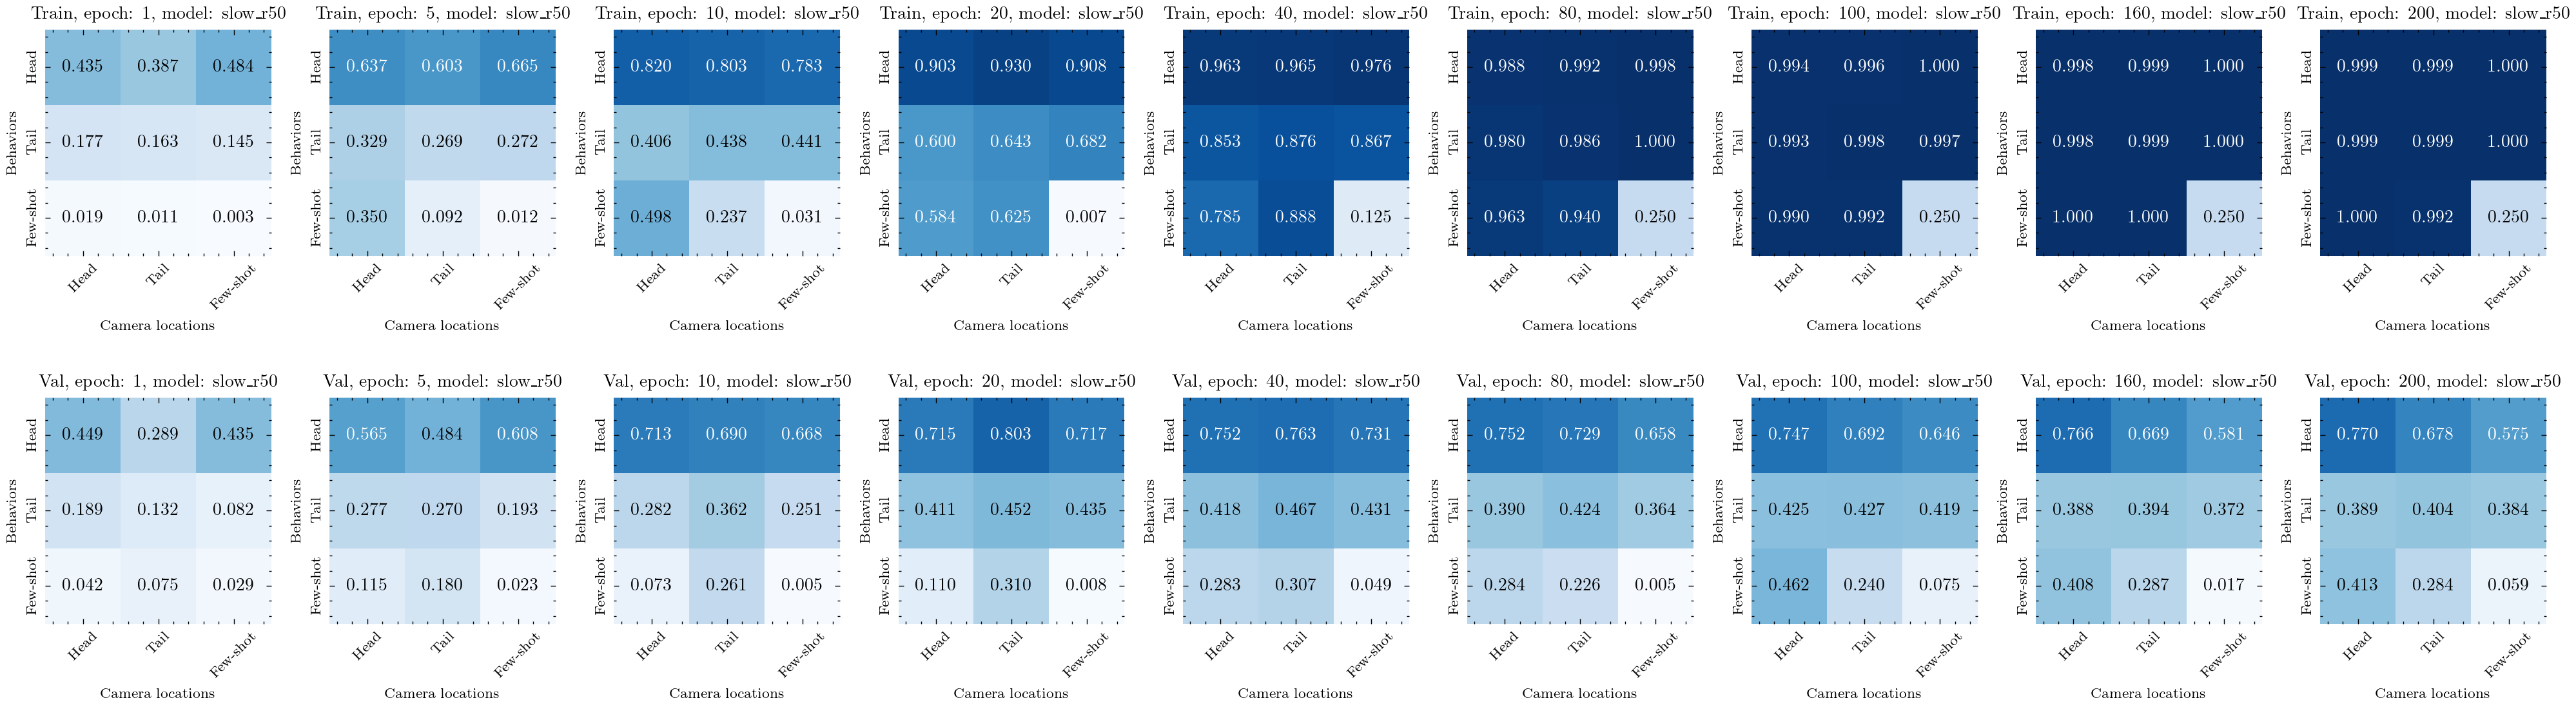

In [6]:


# plot the heatmap for each epoch for train split in first row and val split in the second row
fig, ax = plt.subplots(2, len(datas.keys()), figsize=(20, 6), sharey=False, dpi=200)

for i, epoch in enumerate(datas.keys()):
    plot_heatmap(
        datas[epoch]["train_data"],
        behavioural_dict,
        f"Train, epoch: {epoch}, model: {model_name}",
        ax[0, i],
        labels,
    )

    plot_heatmap(
        datas[epoch]["val_data"],
        behavioural_dict,
        f"Val, epoch: {epoch}, model: {model_name}",
        ax[1, i],
        labels,
    )

plt.tight_layout()
# save as png
fig.savefig(
    os.path.join(figure_saving_path, f"heatmap_{model_name}.png"),
    dpi=200,
    bbox_inches="tight",
)
plt.show()

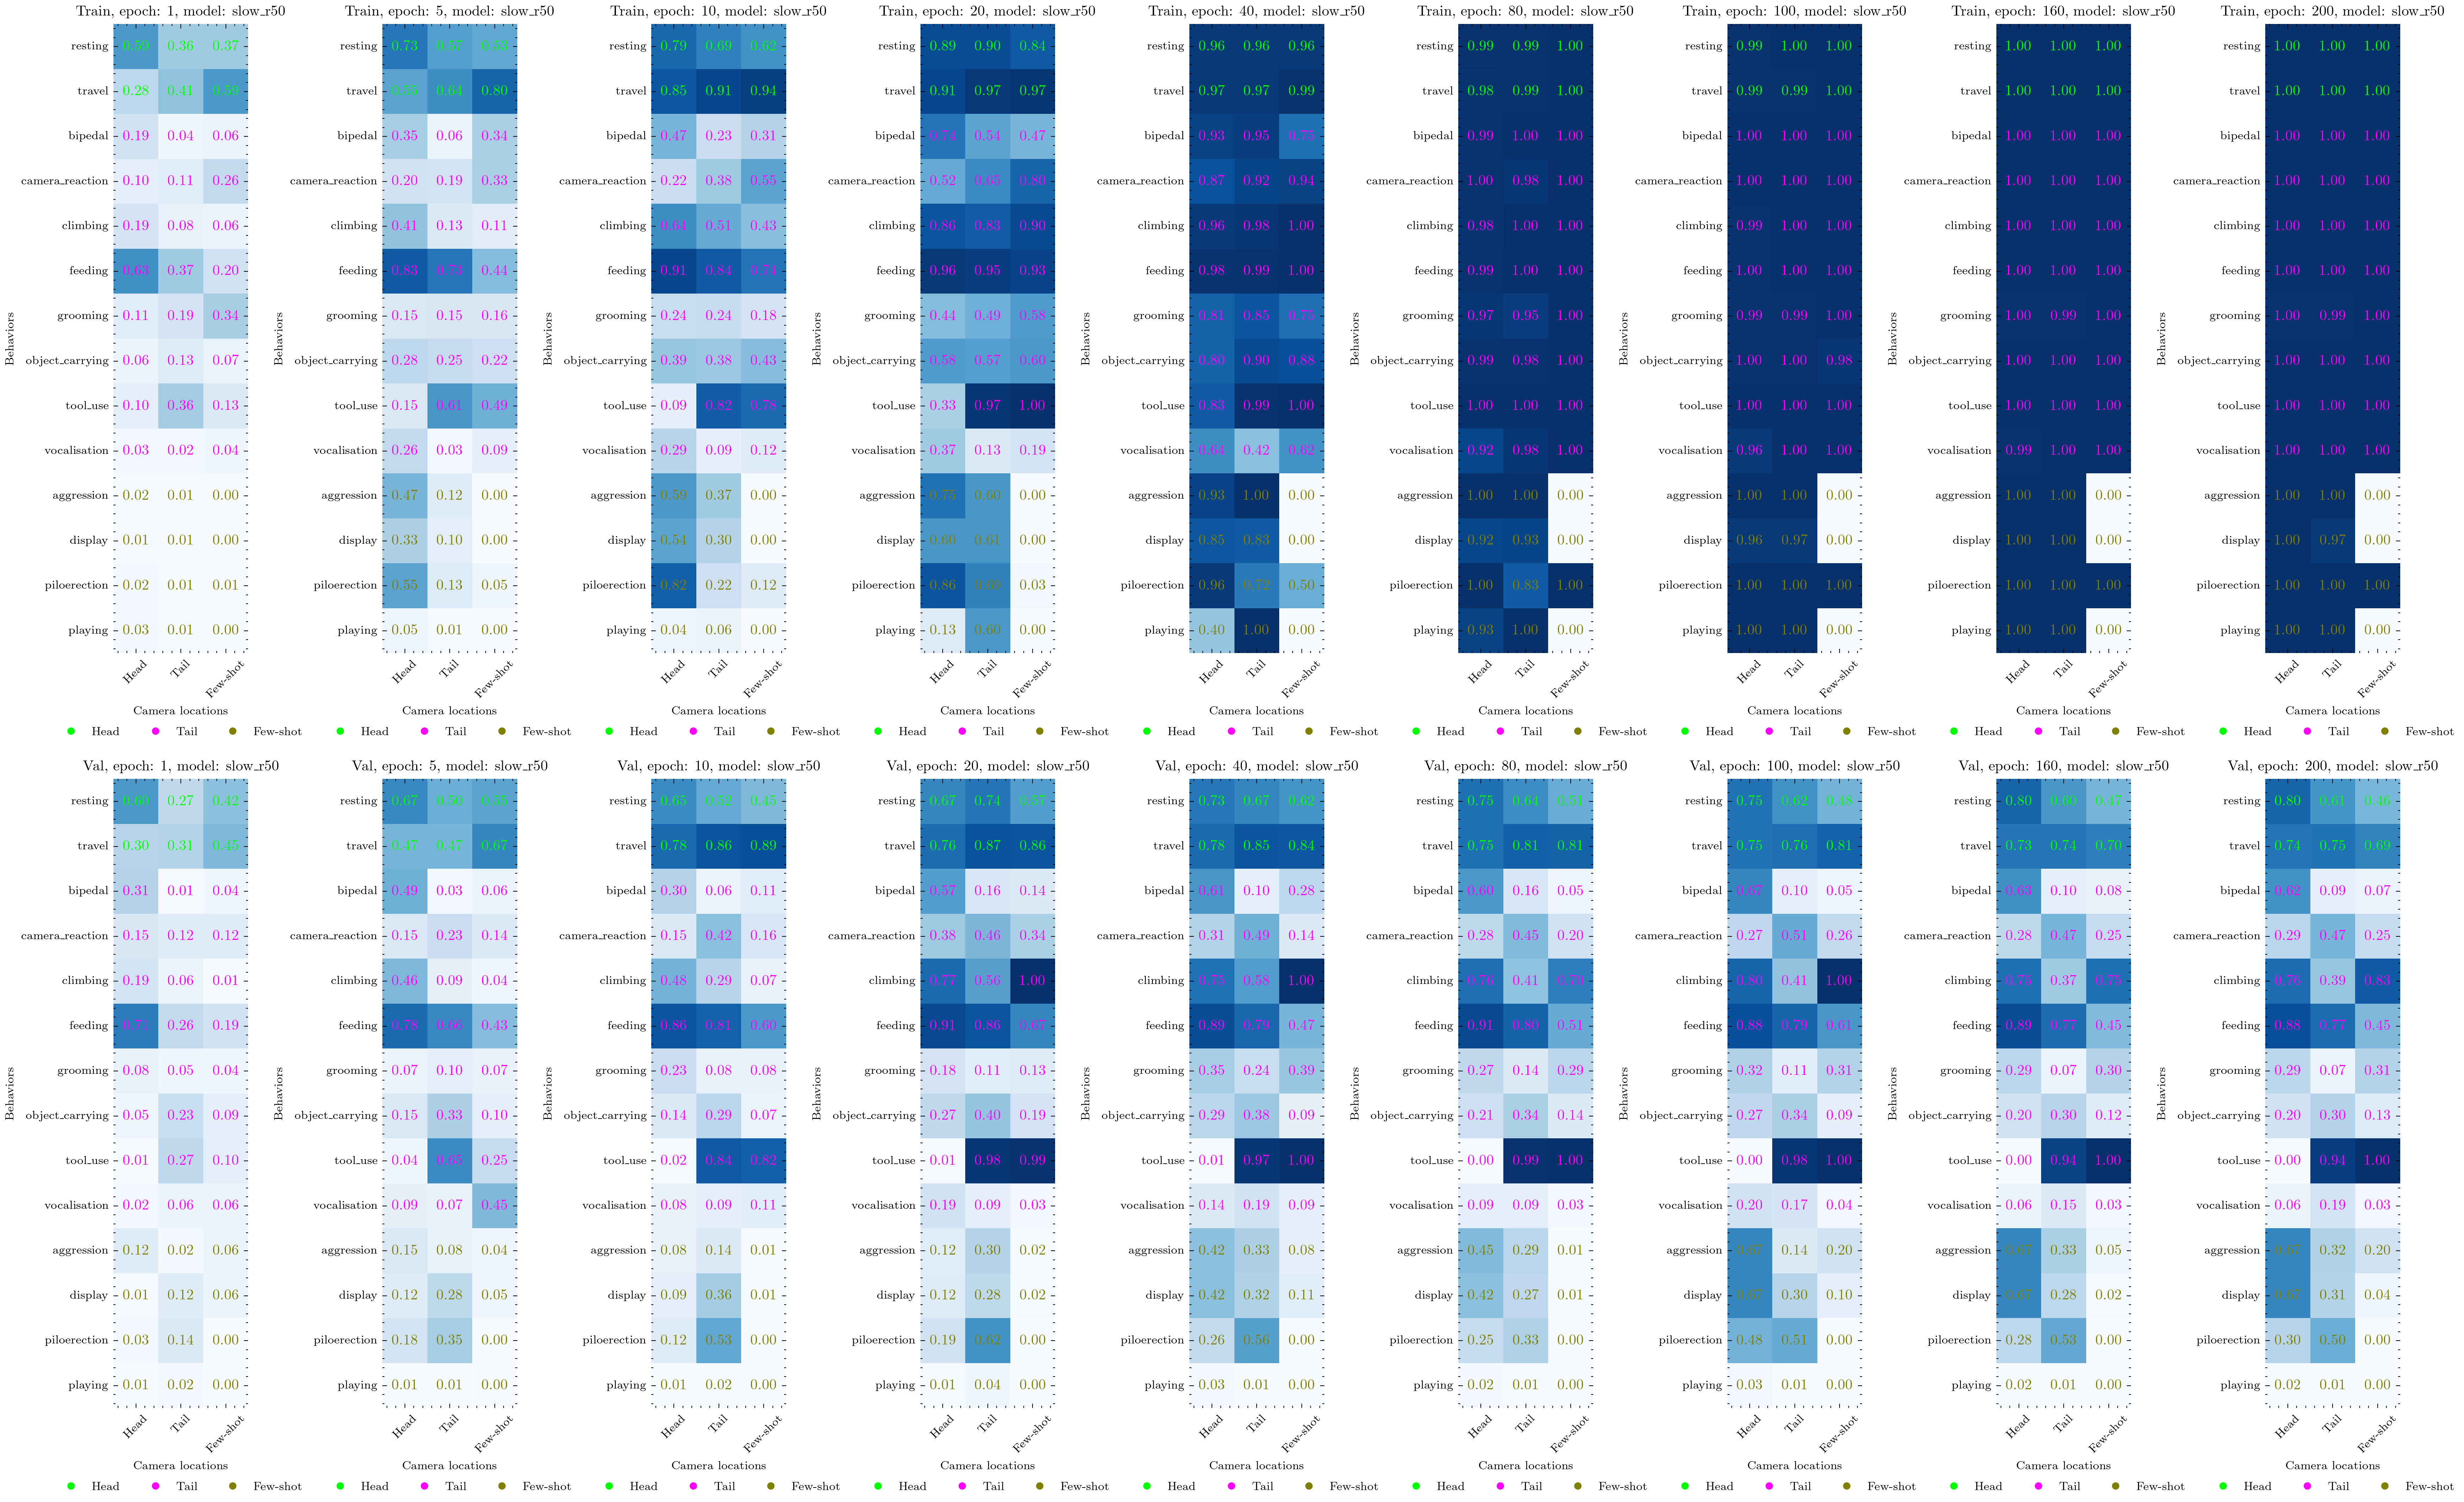

In [7]:
# plot the heatmap for each epoch for train split in first row and val split in the second row
fig, ax = plt.subplots(2, len(datas.keys()), figsize=(29, 17), sharey=False, dpi=300)

for i, epoch in enumerate(datas.keys()):
    
    plot_heatmap(
        data=datas[epoch]["train_data_matrix"],
        behavioural_dict=behavioural_dict,
        title=f"Train, epoch: {epoch}, model: {model_name}",
        ax=ax[0, i],
        labels=labels,
        behaviors=reordered_behaviours,
    )

    plot_heatmap(
        data=datas[epoch]["val_data_matrix"],
        behavioural_dict=behavioural_dict,
        title=f"Val, epoch: {epoch}, model: {model_name}",
        ax=ax[1, i],
        labels=labels,
        behaviors=reordered_behaviours,
    )

# save as png
fig.savefig(
    os.path.join(figure_saving_path, f"heatmap_{model_name}_behaviorswise.png"),
    dpi=300,
)
plt.show()

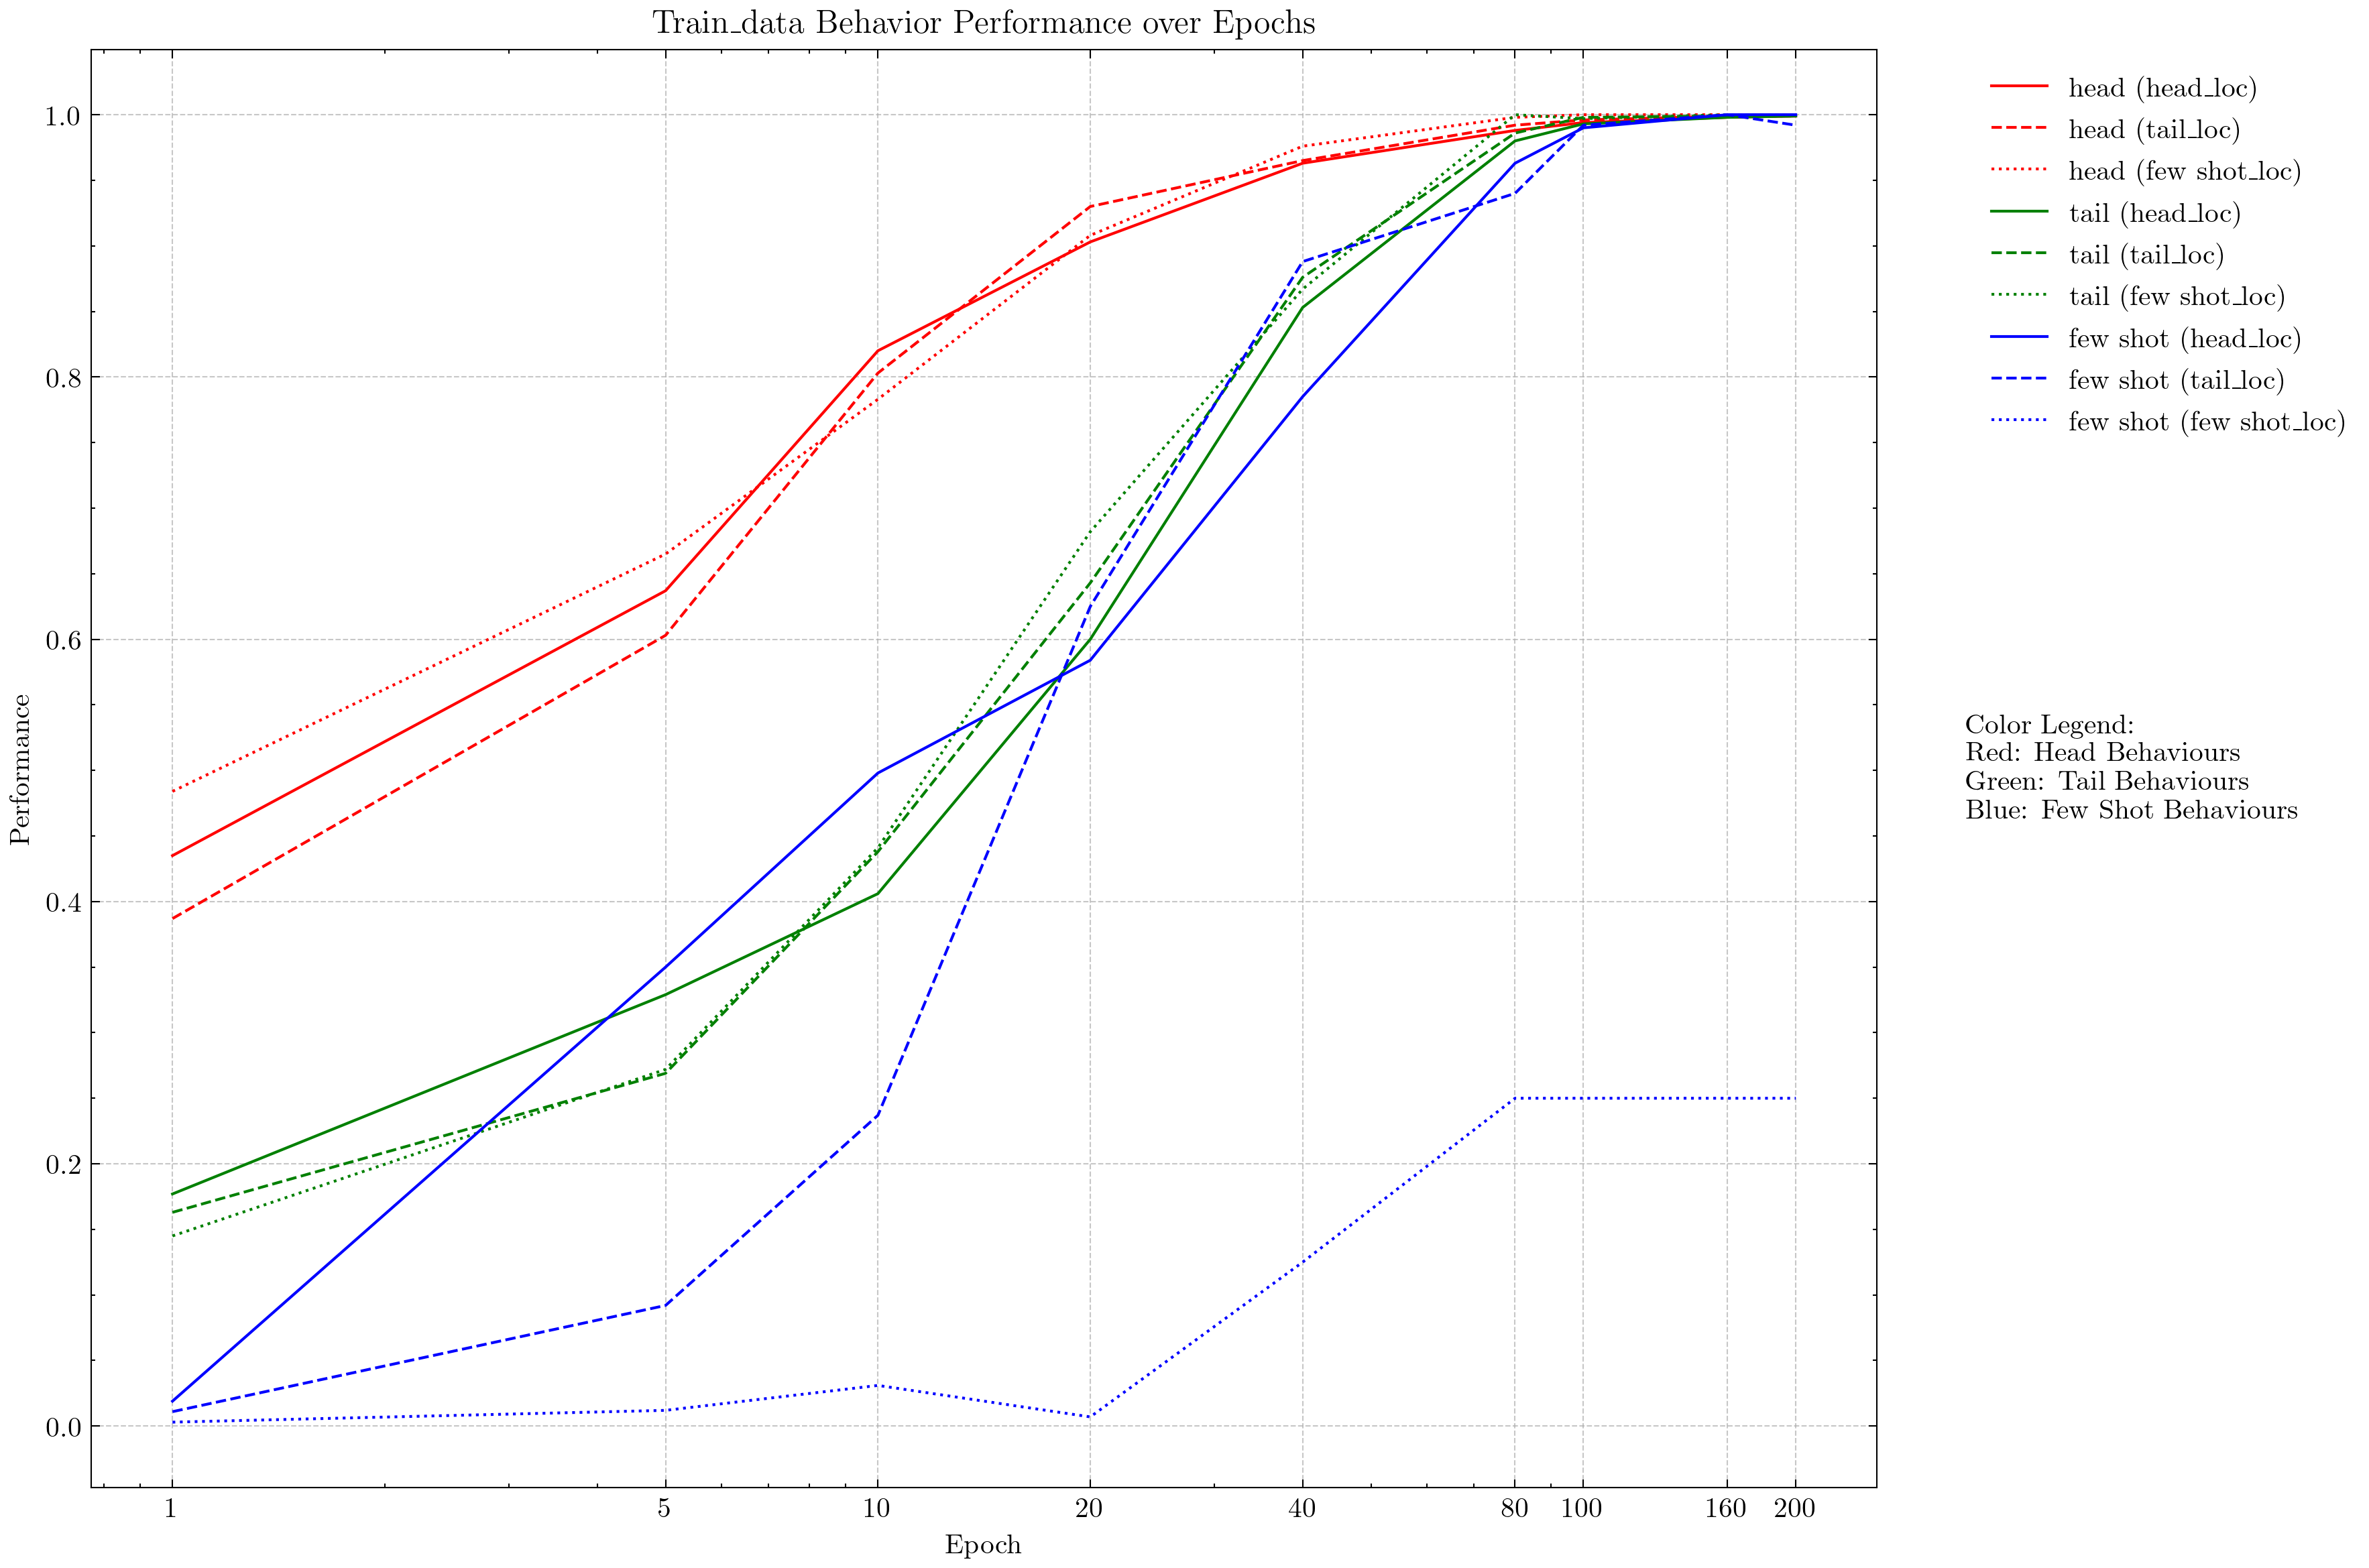

In [8]:
plot_training_progression(datas, split="train_data")

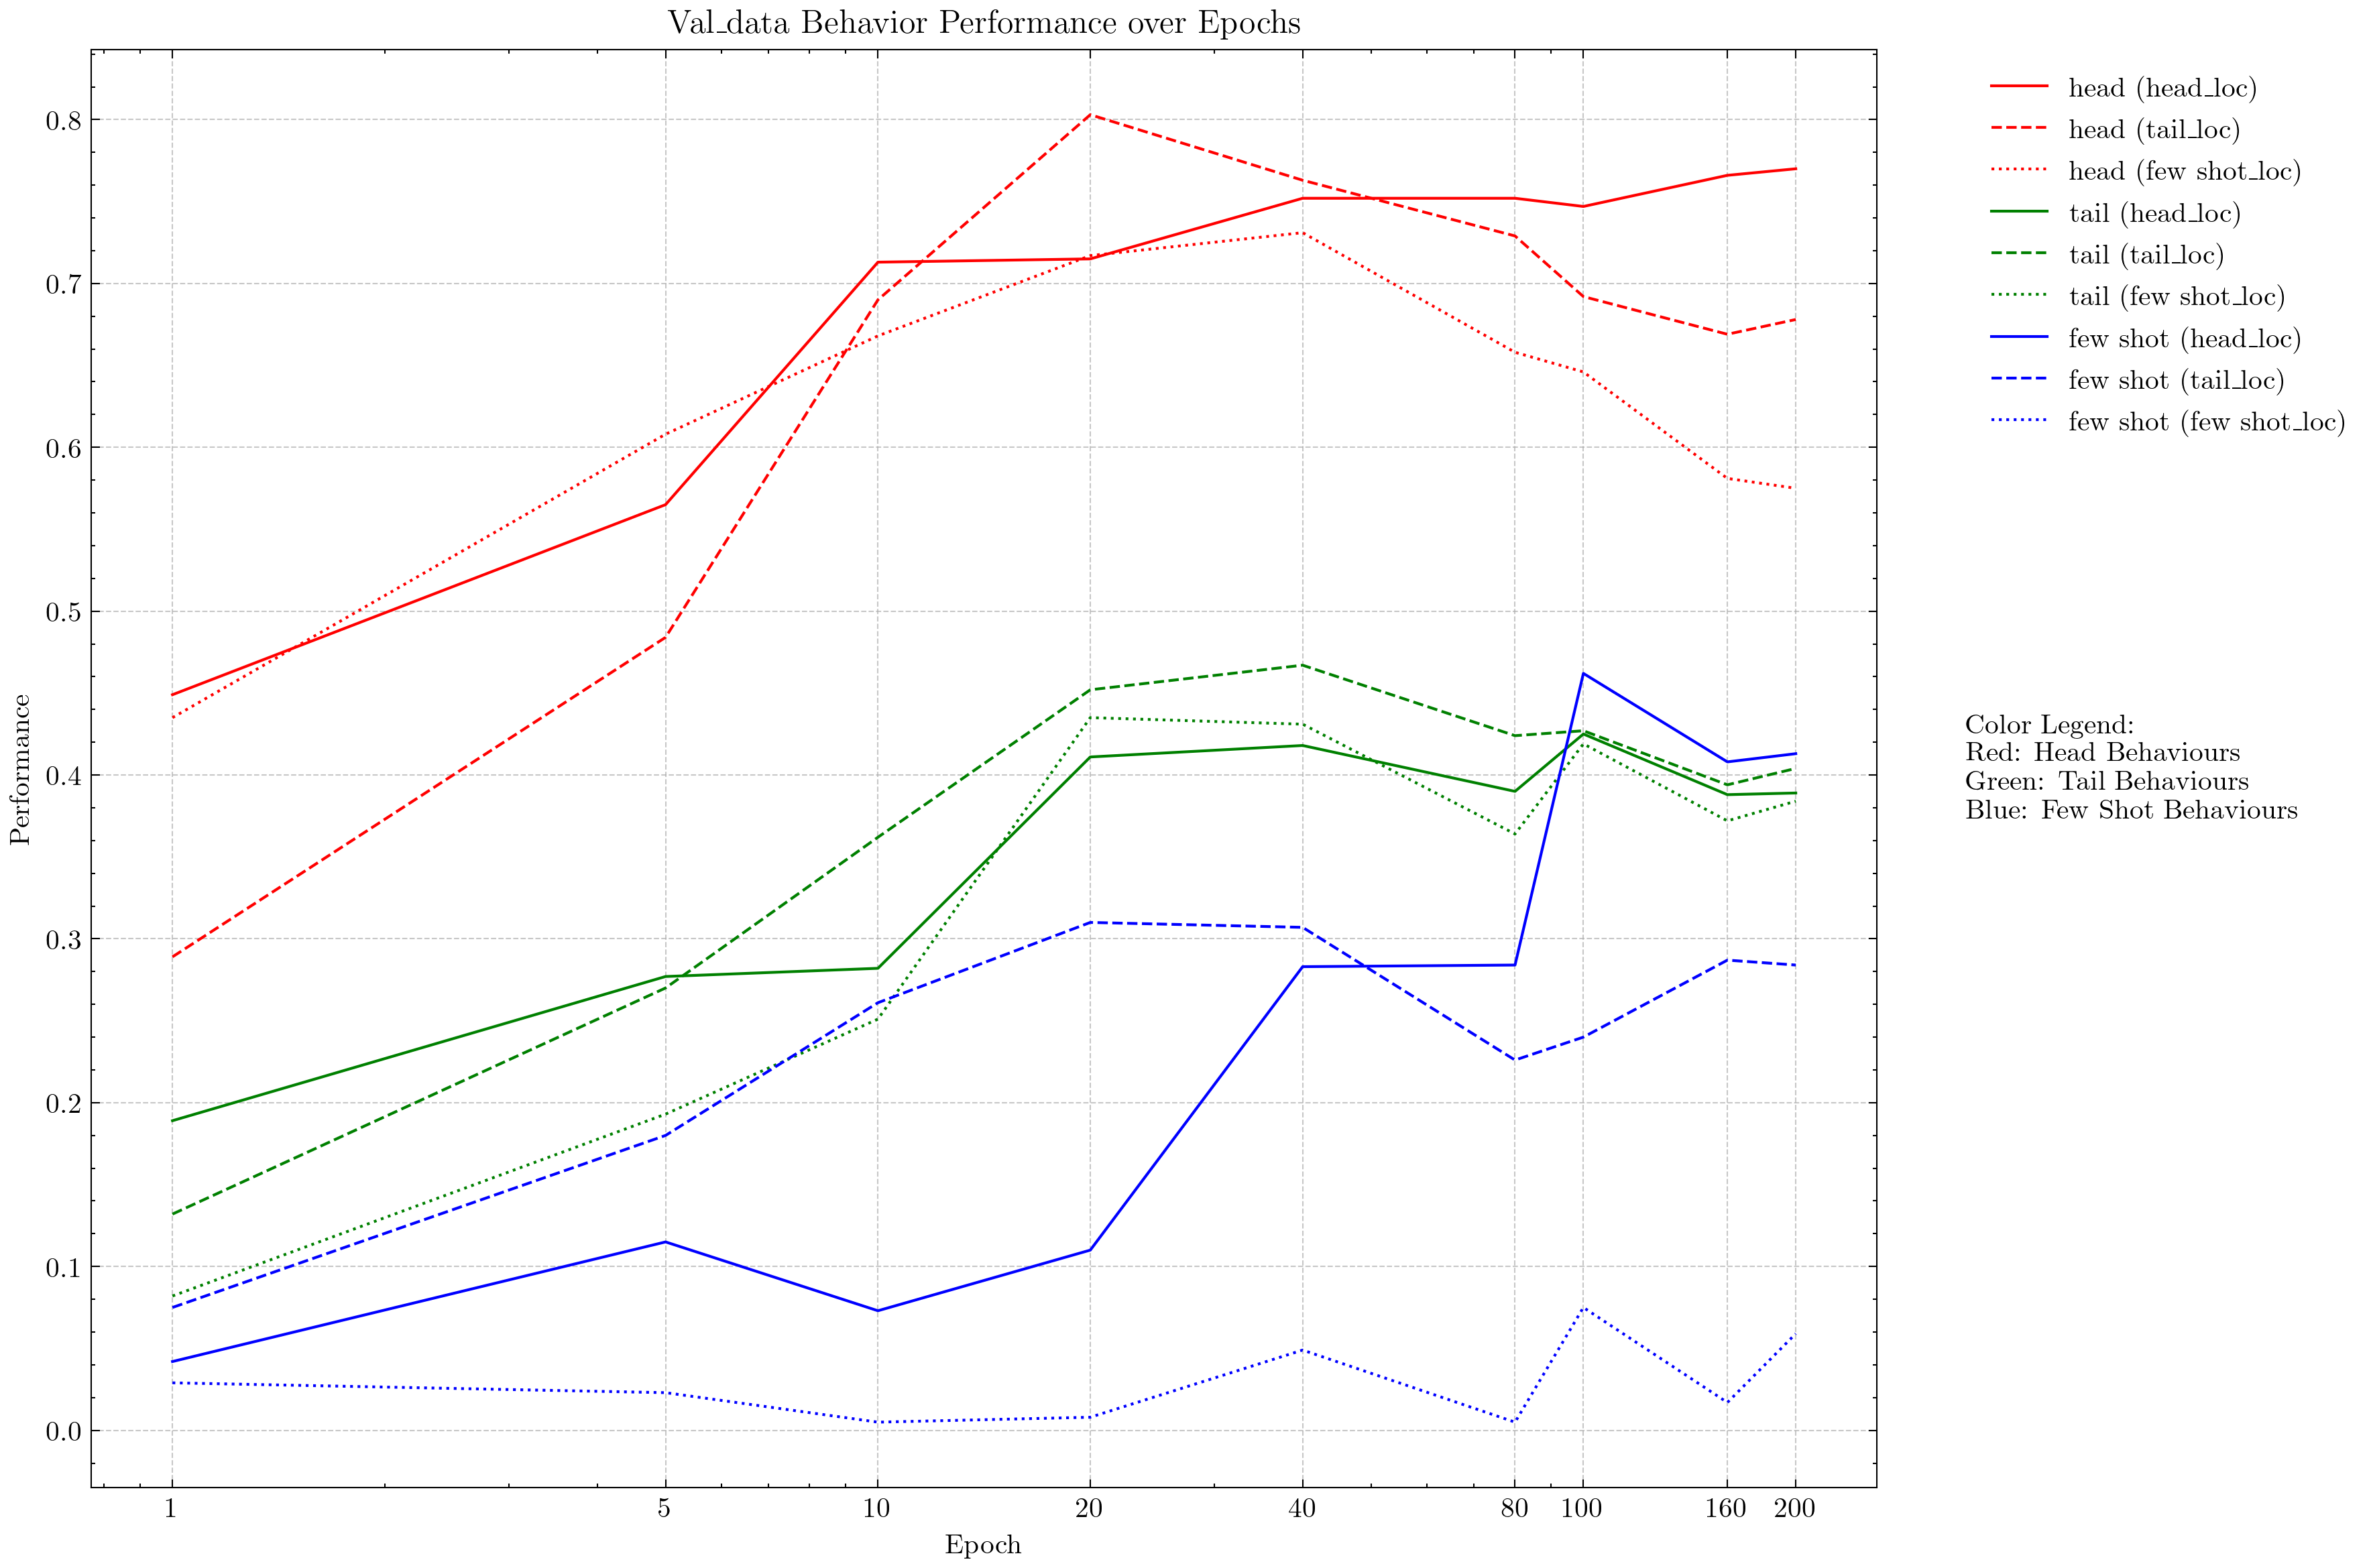

In [9]:
plot_training_progression(datas, split="val_data")

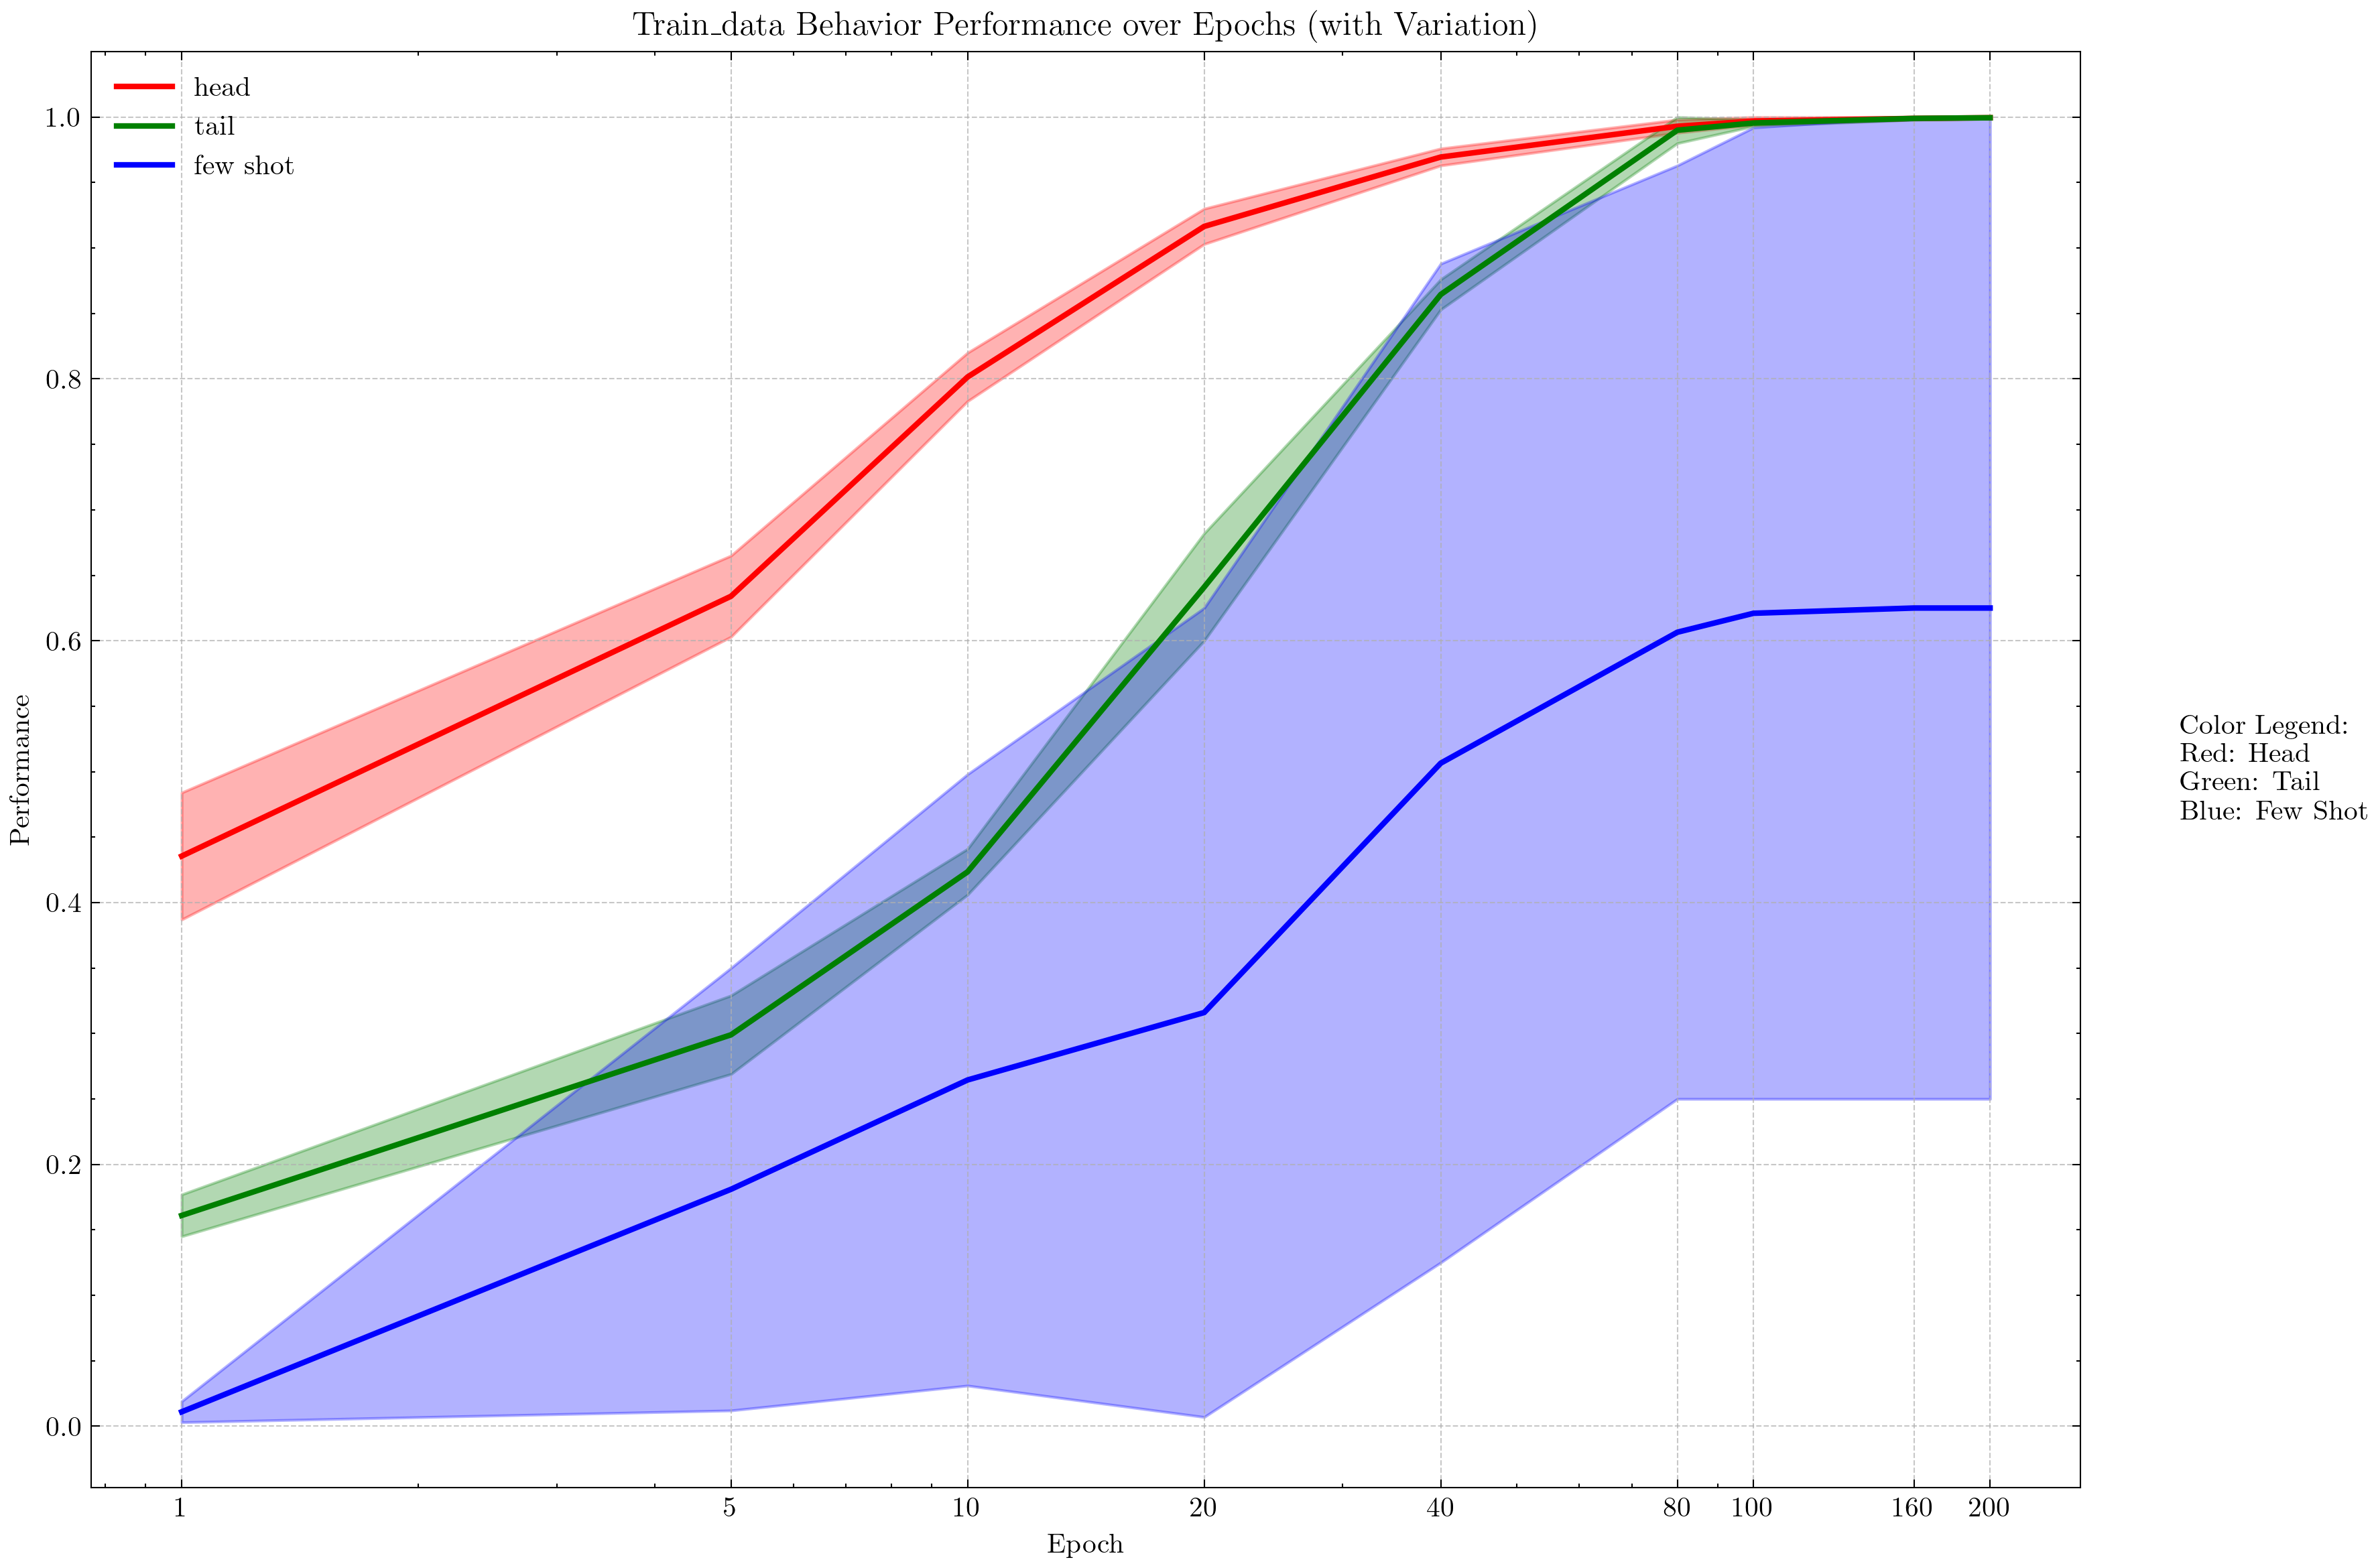

In [10]:
plot_training_progression_with_variation(datas, split="train_data")

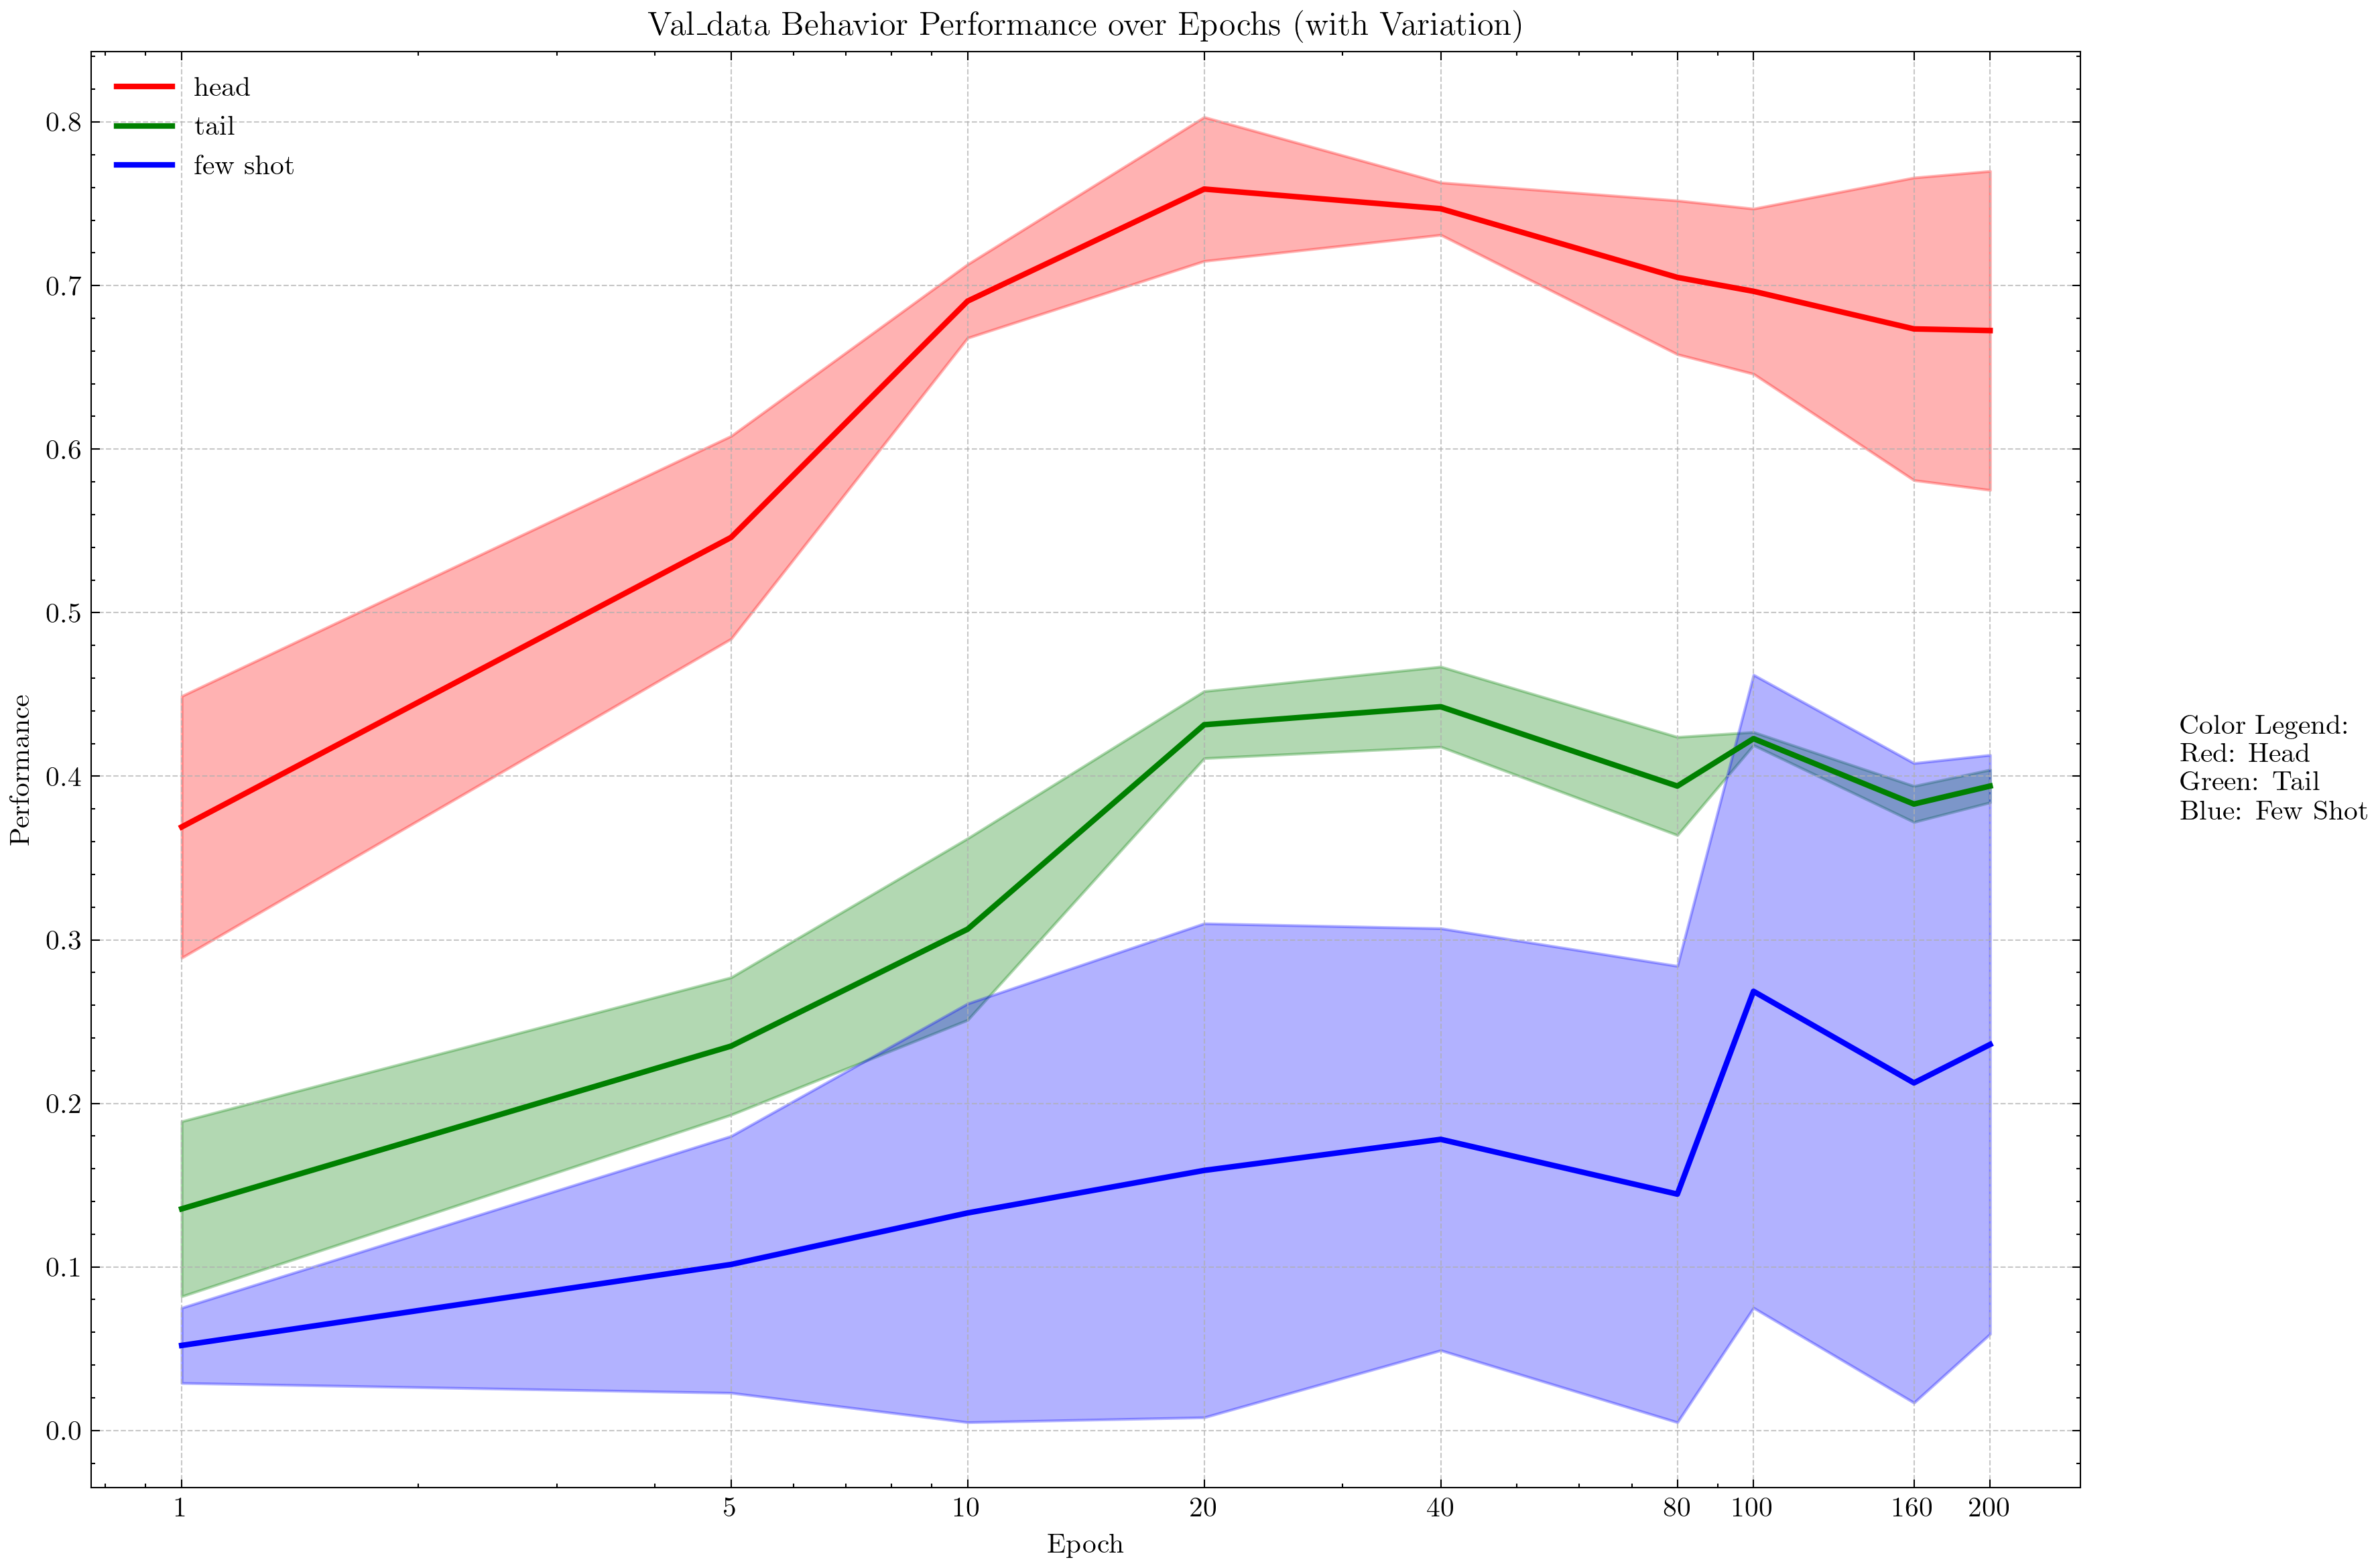

In [11]:
plot_training_progression_with_variation(datas, split="val_data")

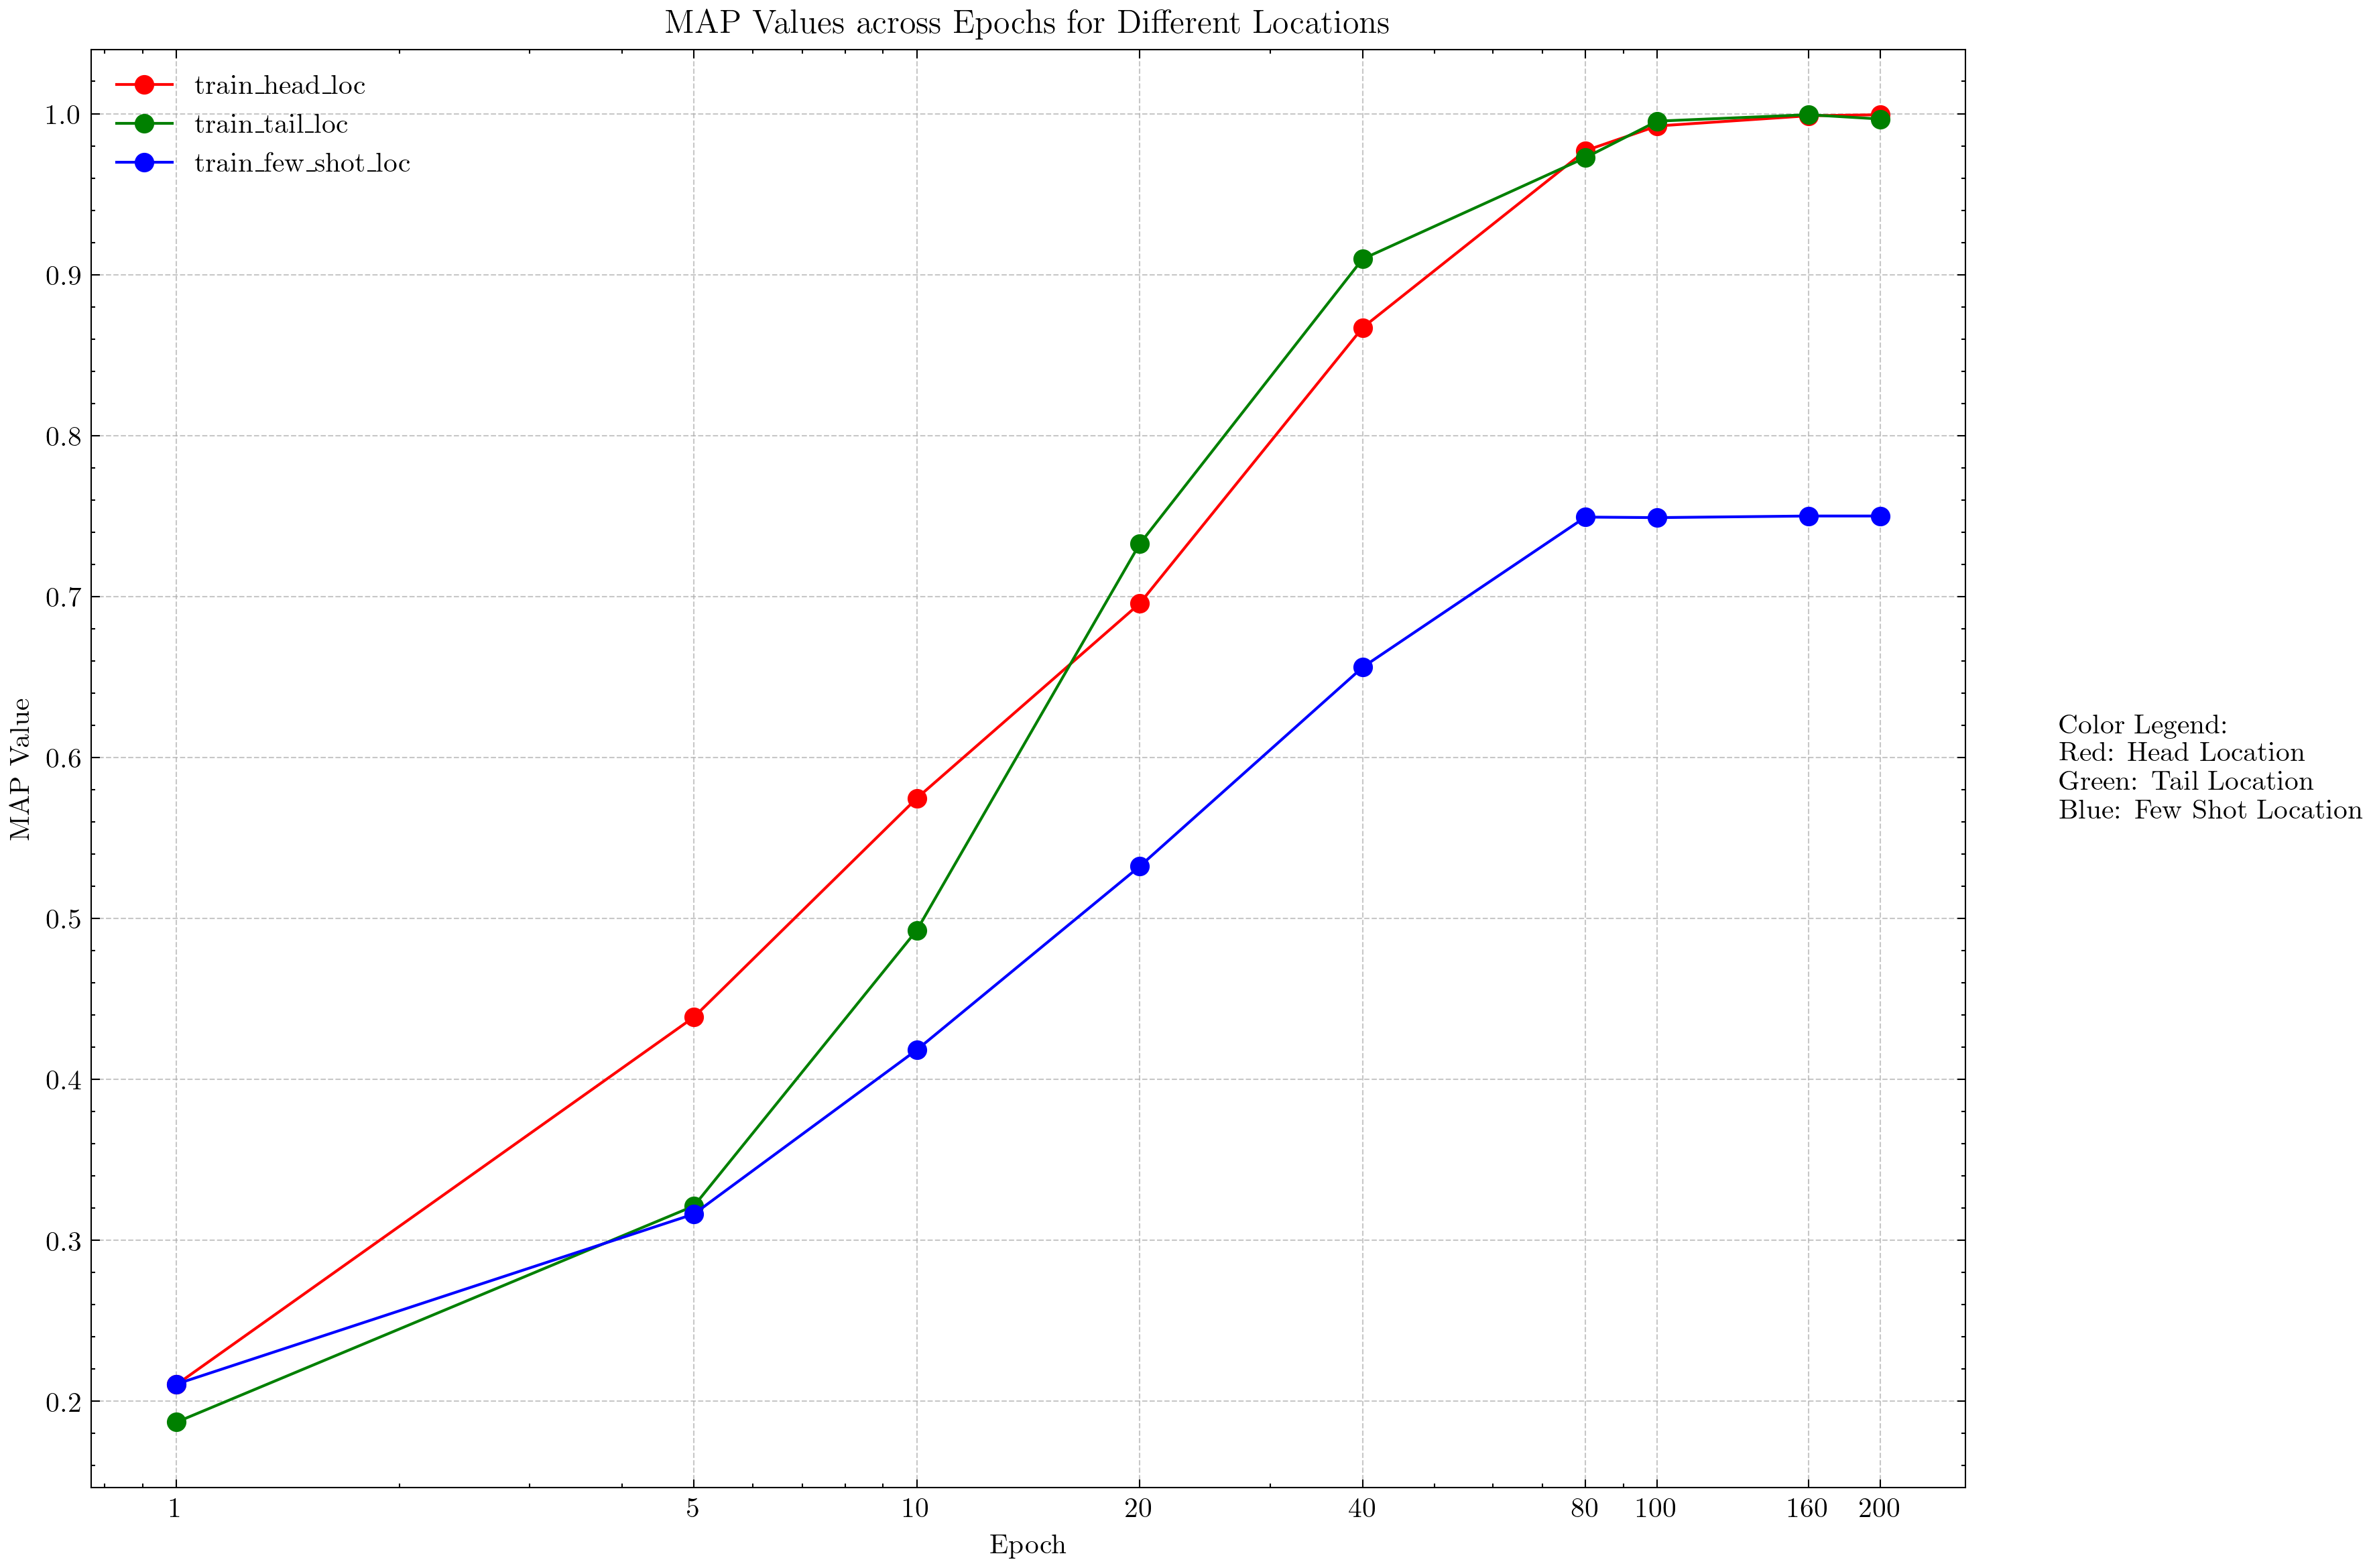

In [12]:
plot_map_values(datas)